<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 3. Continuity
## Diffusion equation in 1D
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve a simple **transient diffusion equation** in one dimension,
using different numerical methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

----
## Theoretical model

We start defining the transient diffusion equation. We describe a quantity $c(x,t)$ in an incompressible fluid,
which changes its position only through diffusion of the particle quantity:
$$
\fbox{$
\frac{\partial c(x,t)}{\partial t} - D \frac{\partial^2 c(x,t)}{\partial x^2} = 0
$}
$$
with
$x$ [m] the position,
$t$ [s] time,
$D$ [m$^2$/s] the diffusivity, and
$\Delta t$ [s] the time increment.

The transient advection equation is a **hyperbolic partial differential equation**, which has a unique
solution for the **initial condition**:
$$
c(x,t=0) = c_0(x,0)
$$

----
## Gaussian function

We define the `Gaussian` function with mean $\mu$ and standard deviation $\sigma$:
$$
c(x,t) = e^{-\frac{(x-vt-\mu)^2}{\sigma^2}}
$$
which is a solution of the transient diffusion equation.


In [2]:
def gaussian(x,v=0.,t=0.,mu=5.,sigma=1.):
    f = np.exp(-(x-v*t-mu)**2/(sigma)**2)
    return f

In [3]:
xstep = 101
x = np.linspace(0,10,xstep)

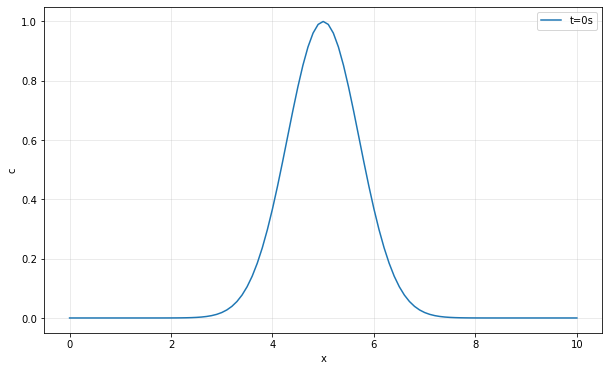

In [4]:
u0 = gaussian(x)

plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0s')
plt.legend()

----
## Numerical solution methods

Next, we derive several numerical methods, which can be used to solve the transient advection equation.
We first need to assign the temporal and spatial time steps, $\Delta t$ [s] and $\Delta x$ [m], 
the velocity $v$ [m/s], and the diffusivity $D$ [m$^2$/s]:

In [5]:
dt = 0.05   # s
dx = (x.max()-x.min()) / (xstep-1)   # m
v  = 0.0   # m/s
D  = 0.1   # m2/s

Thus we have discretised both spatial and temporal variables:
$$
\begin{array}{rcl}
t_n &=& t_0 + n \Delta T, \quad n=0,N \\
x_i &=& x_0 + i \Delta x, \quad i=0,I
\end{array}
$$

The `Courant number`, defined as
$$
Co = \frac{D \Delta t}{\Delta x^2}
$$
defines the stability of the numerical solutions. Explicit solutions are stable
for $Co <1$.

In [6]:
Courant = D*dt/dx/dx
print ('Courant number: ',np.round(Courant,4))

Courant number:  0.5


----
## FTCS explicit scheme (forward time centered space)

Our first scheme is called `FTCS`, forward time, centered space, thus the derivatives in the
transient advection equations are replaced by **forward differences in time** and 
**central differences is space**:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
D \frac{c_{i+1}^{n}-2 c_{i}^{n} + c_{i-1}^{n}}{\Delta x^2}
$$
or solved for the next time step
$$
c_{i}^{n+1}
=
\left( 1-2\alpha \right) c_{i}^{n} 
+ \alpha \left( c_{i+1}^{n} + c_{i-1}^{n} \right)
$$
with
$$
\alpha = D \frac{\Delta t}{\Delta x^2}
$$

<img src="images/PDE_FTCSexplicit.jpg" style="height:5cm;">

We implement the FTCS explicit method:

In [7]:
# start time
t = 0
# initial values
u = gaussian(x)
alpha = D*dt/dx/dx

# solution
for n in range(200):
    t = t + dt
    uold = u
    for i in range(1,u.shape[0]-1):
        u[i] = (1-2*alpha)*uold[i] + alpha*(uold[i+1]+uold[i-1])
    if (np.abs(t-4) < dt/2):
        u50 = np.copy(u)
    elif (np.abs(t-8) < dt/2):
        u100 = np.copy(u)
    elif (np.abs(t-10) < dt/2):
        u150 = np.copy(u)

In [8]:
print(x[np.where(u0 == np.amax(u0))],u0[np.where(u0 == np.amax(u0))])
print(x[np.where(u50 == np.amax(u50))],u50[np.where(u50 == np.amax(u50))])
print(x[np.where(u100 == np.amax(u100))],u100[np.where(u100 == np.amax(u100))])
print(x[np.where(u150 == np.amax(u150))],u150[np.where(u150 == np.amax(u150))])

[5.] [1.]
[4.9] [0.48980002]
[4.9] [0.36840365]
[4.9] [0.33391377]


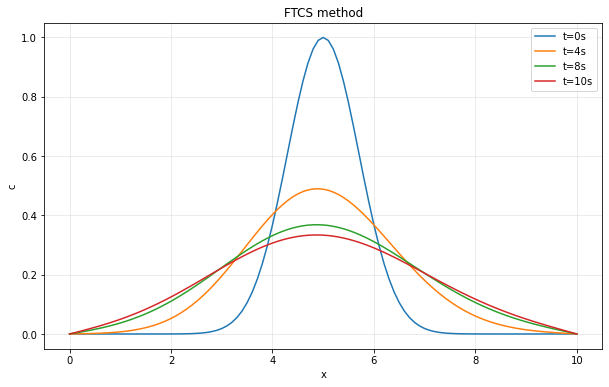

In [9]:
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0s')
plt.plot(x,u50,label='t=4s')
plt.plot(x,u100,label='t=8s')
plt.plot(x,u150,label='t=10s')
plt.title('FTCS method')
plt.legend()

----
## DuFort-Frankel scheme

Our second scheme is the `DuFort-Frankel scheme`, which reads:
$$
\frac{c_{i}^{n+1}-c_{i}^{n-1}}{2 \Delta t}
=
D \frac{c_{i+1}^{n}-2 \frac{c_{i}^{n+1} + c_{i}^{n-1}}{2} + c_{i-1}^{n}}{\Delta x^2}
$$
or solved for the next time step
$$
c_{i}^{n+1}
=
\frac{1-\alpha'}{1+\alpha'} c_{i}^{n-1} 
+ \frac{\alpha'}{1+\alpha'} \left( c_{i+1}^{n}+c_{i-1}^{n} \right)
$$
with
$$
\alpha' = 2 D \frac{\Delta t}{\Delta x}
$$
Note that we need **two older time steps**, $c_{i}^{n}$ and $c_{i}^{n-1}$!
We therefore use the FTCS explicit method for the first time step generation...

<img src="images/PDE_DuFord_Frankel.jpg" style="height:5cm;">

We implement the DuFort-Frankel method:

In [10]:
# start time
t = 0
# initial values
u = gaussian(x)
# first step with FTCS explicit
uold = u
alpha = D*dt/dx/dx
t = t + dt
for i in range(1,u.shape[0]-1):
        u[i] = (1-2*alpha)*uold[i] + alpha * (uold[i+1]+uold[i-1])

# sub-sequent steps with DuFord-Frankel
alphap = D*dt/dx/dx
for n in range(1,200):
    t = t + dt
    uveryold = uold
    uold = u
    for i in range(1,u.shape[0]-1):
        u[i] = (1-alphap)/(1+alphap)*uveryold[i] + alphap/(1+alphap) * (uold[i+1]+uold[i-1])
    if (np.abs(t-4) < dt/2):
        u50 = np.copy(u)
    elif (np.abs(t-8) < dt/2):
        u100 = np.copy(u)
    elif (np.abs(t-10) < dt/2):
        u150 = np.copy(u)

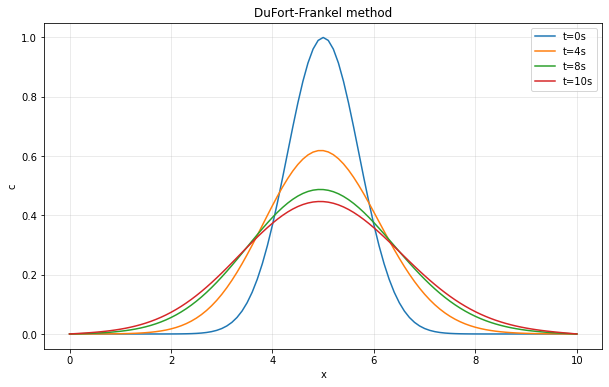

In [11]:
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0s')
plt.plot(x,u50,label='t=4s')
plt.plot(x,u100,label='t=8s')
plt.plot(x,u150,label='t=10s')
plt.title('DuFort-Frankel method')
plt.legend()

----
## Crank-Nicolson method

Our third scheme is called `Crank-Nicolson method`, which is an **implicit** method:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
D \frac{
\left( c_{i+1}^{n+1} - 2 c_{i}^{n+1} + c_{i-1}^{n+1} \right) +
\left( c_{i+1}^{n} - 2 c_{i}^{n} + c_{i-1}^{n} \right)
}{2 \Delta x^2}
$$
With
$\alpha=\frac{D \Delta t}{\Delta x^2}$, we can recast the equation into a system of linear equations:
$$
-\alpha c_{i+1}^{n+1} + 2 (1+\alpha) c_{i}^{n+1} -\alpha c_{i-1}^{n+1}
=
\alpha c_{i+1}^{n} + 2 (1-\alpha) c_{i}^{n} +\alpha c_{i-1}^{n}
$$
The right-hand side is known, thus we have a tridiagonal linear system:
$$
\mathbf{A} \mathbf{c} = \mathbf{b}
$$

<img src="images/PDE_Crank_Nicolson.jpg" style="height:5cm;">

We implement the Crank-Nicholson method:

In [14]:
# start time
t = 0
alpha = D*dt/dx/dx
# initial values
u = gaussian(x)
# initialise matrix A and rhs vector b
A = np.zeros(len(u)*len(u)).reshape(len(u),len(u))
b = np.zeros(len(u))
print(A.shape)
print(b.shape)

for n in range(200):
    t = t + dt
    uold = u
    for i in range(len(u)):
        # fill matrix
        if (i != 0):
            A[i,i-1] = - alpha
        A[i,i]   = + 2*(1+alpha)
        if (i != len(u)-1):
            A[i,i+1] = - alpha
        # fill rhs vector  
        b[i] = 2*(1-alpha)*uold[i]
        if (i != 0):
            b[i] = b[i] + alpha*uold[i-1]
        if (i != len(u)-1):
            b[i] = b[i] + alpha*uold[i+1]
    # solve linear sytem
    u = np.linalg.solve(A,b)
    if (np.abs(t-4) < dt/2):
        u50 = np.copy(u)
    elif (np.abs(t-8) < dt/2):
        u100 = np.copy(u)
    elif (np.abs(t-10) < dt/2):
        u150 = np.copy(u)

(101, 101)
(101,)


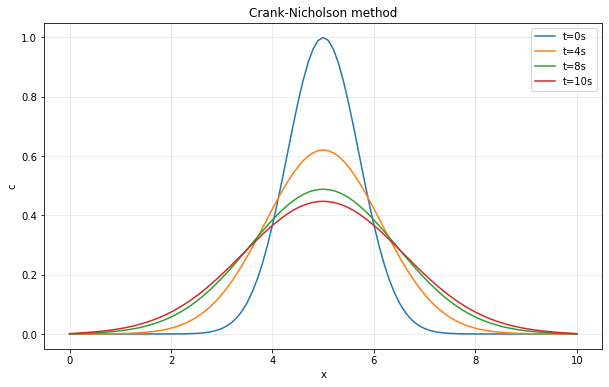

In [15]:
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.plot(x,u0,label='t=0s')
plt.plot(x,u50,label='t=4s')
plt.plot(x,u100,label='t=8s')
plt.plot(x,u150,label='t=10s')
plt.title('Crank-Nicholson method')
plt.legend()

... done